## INTRODUCTION 



## LITERATURE REVIEW

## METHODS

### Data collection and preprocessing

### Descriptive Analysis: Visualization and data preparation

### Datapreparation

### Stationarity

### VAR-Model and Granger-Causality Test




##  RESULTS

## APPENDIX

In [31]:
# Package installation
# install.packages('dplyr')
# install.packages('jsonlite')
# install.packages('lubridate')
# install.packages('ggplot2')
# install.packages('quantmod')
# install.packages('lifecycle')
# install.packages('tidyselect')
# install.packages("tidyverse")
# install.packages("zoo")

# Install necessary packages for VAR model
# install.packages("tsibble")
# install.packages("feasts")
# install.packages("fabletools")


In [32]:
# Load necessary libraries
library(dplyr)
library(jsonlite)
library(lubridate)
library(ggplot2)
library(quantmod)
library(lifecycle)
library(tidyselect)
library(tidyverse)
library(zoo)
library(forecast)
library(tseries)

# Load necessary libraries for VAR model
library(tsibble)
library(feasts)
library(fabletools)



In [33]:
# Read the CSV file into a dataframe
WIN_PRO_df <- read.csv("csv_files/win_data_pro.csv")
PLACE_PRO_df <- read.csv("csv_files/place_data_PRO.csv")

In [34]:
# Filter only on the rows where actual trades have been made
WIN_PRO_df <- WIN_PRO_df %>% filter(trades != "[]")
PLACE_PRO_df <- PLACE_PRO_df %>% filter(trades != "[]")

# Convert timestamp to POSIXct
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

Bucket_size <- 9

# Create a equal frequency bin for time
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(time_bucket = floor(as.numeric(timestamp) / Bucket_size))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(time_bucket = floor(as.numeric(timestamp) / Bucket_size))

# Create price column. Price is set to last traded price, which is fine because we filtered out the rows with no trades.
#Hence price is now actual trades, and size will be worked out later for each horse.
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(
    price = last_traded_price
  )

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(
    price = last_traded_price
  )


In [35]:
###Check horse IDS
# Read the horse name data into a dataframe
horse_names_df <- data.frame(
  horse_id = c(8421889, 7560122, 5465145, 3415981, 5105924, 7401388),
  horse_name = c("Romsdal", "Snow Sky", "Havana Beat", "Times Up", "Brown Panther", "Island Remede")
)

In [36]:
# Join the horse name data with the main dataframe
WIN_PRO_df <- WIN_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

In [37]:
# Important instances to split df
PP_t <- "2015-05-15 16:06:18"
IP_t <- "2015-05-15 16:16:00"


# Split the data frame into three parts based on the given times
WIN_PRO_df_Morning <- WIN_PRO_df %>% filter(timestamp < PP_t)
WIN_PRO_df_PP <- WIN_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
WIN_PRO_df_IP <- WIN_PRO_df %>% filter(timestamp >= IP_t)

PLACE_PRO_df_Morning <- PLACE_PRO_df %>% filter(timestamp < PP_t)
PLACE_PRO_df_PP <- PLACE_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
PLACE_PRO_df_IP <- PLACE_PRO_df %>% filter(timestamp >= IP_t)

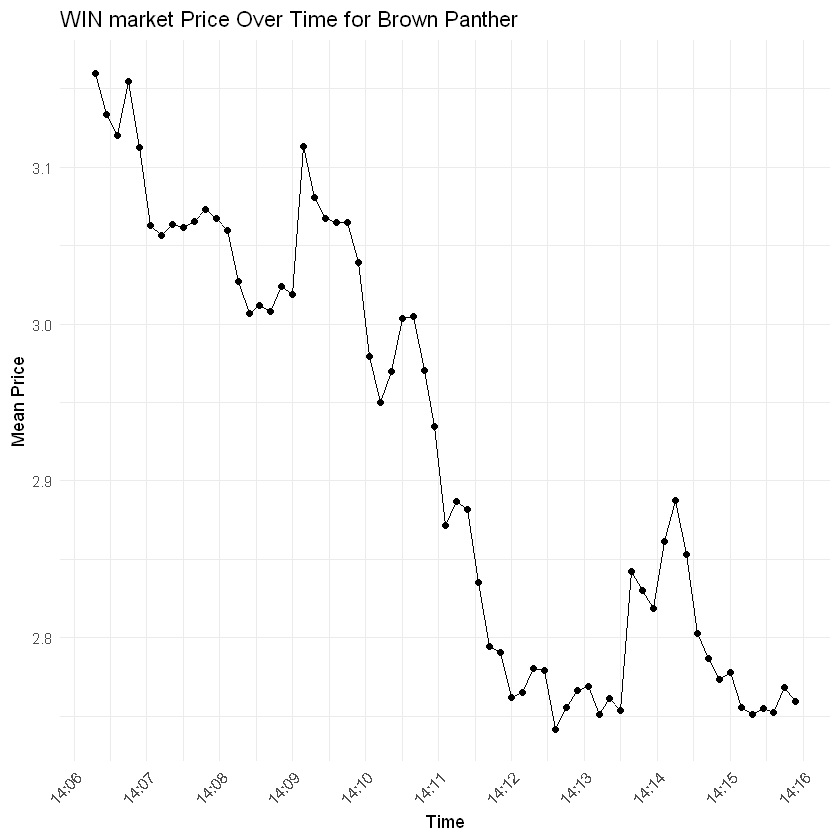

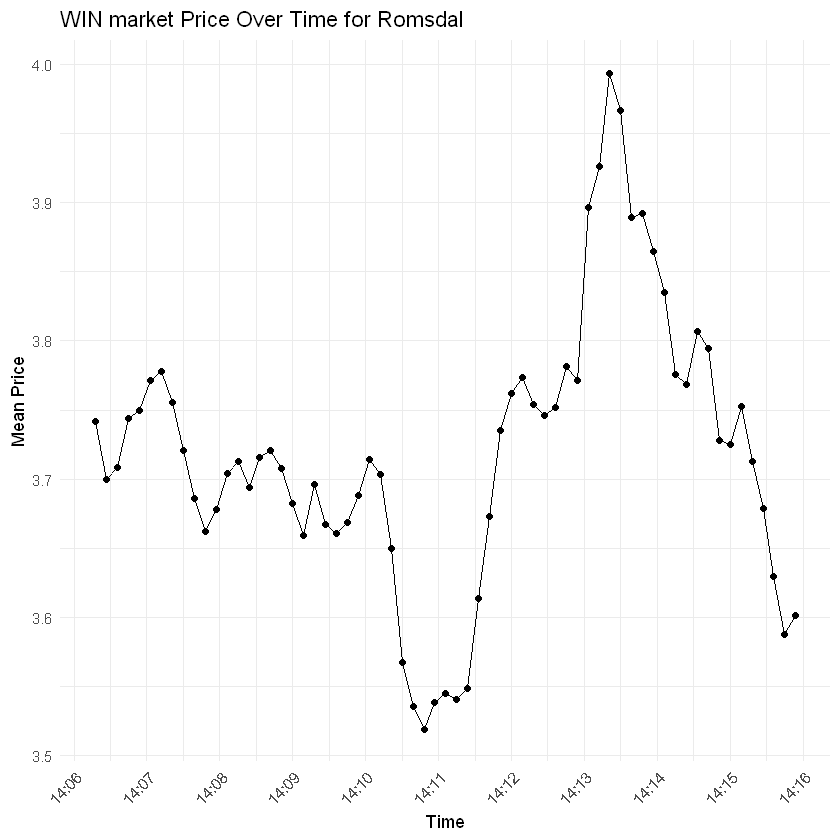

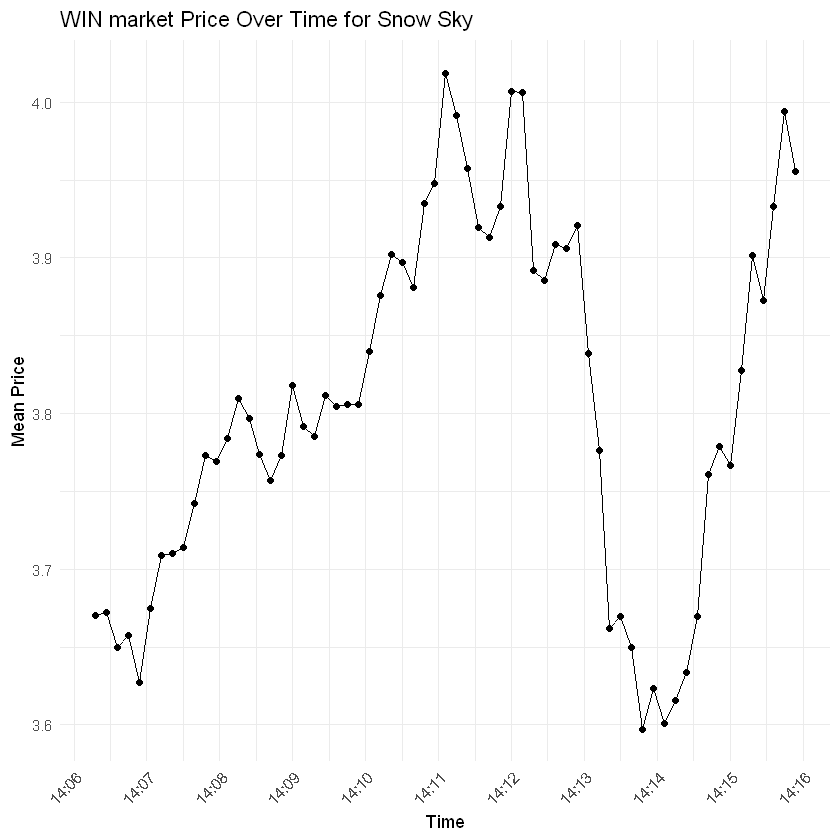

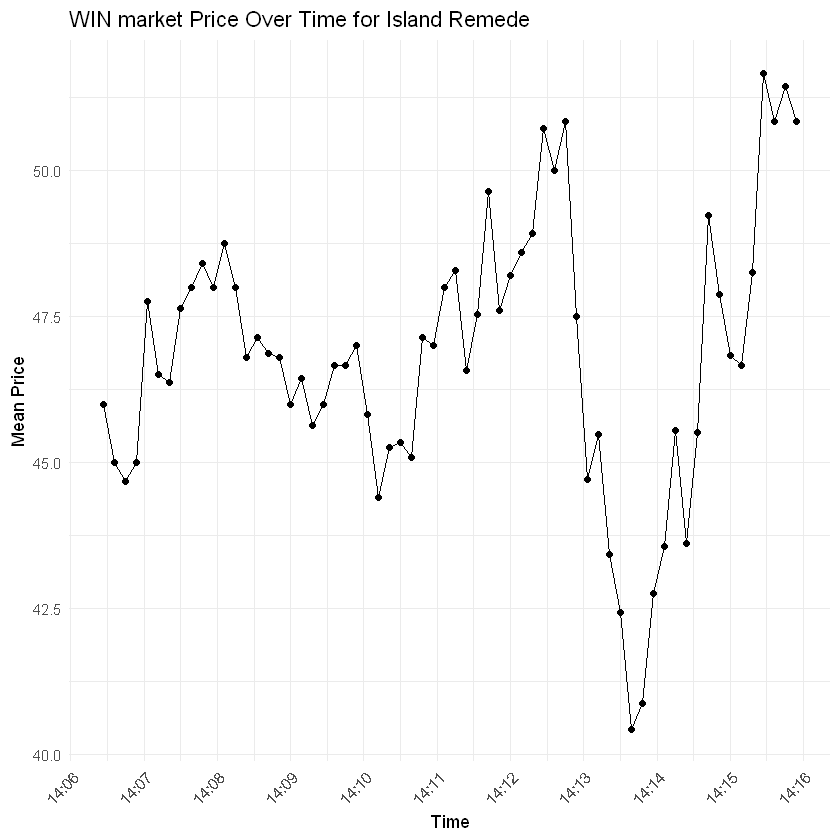

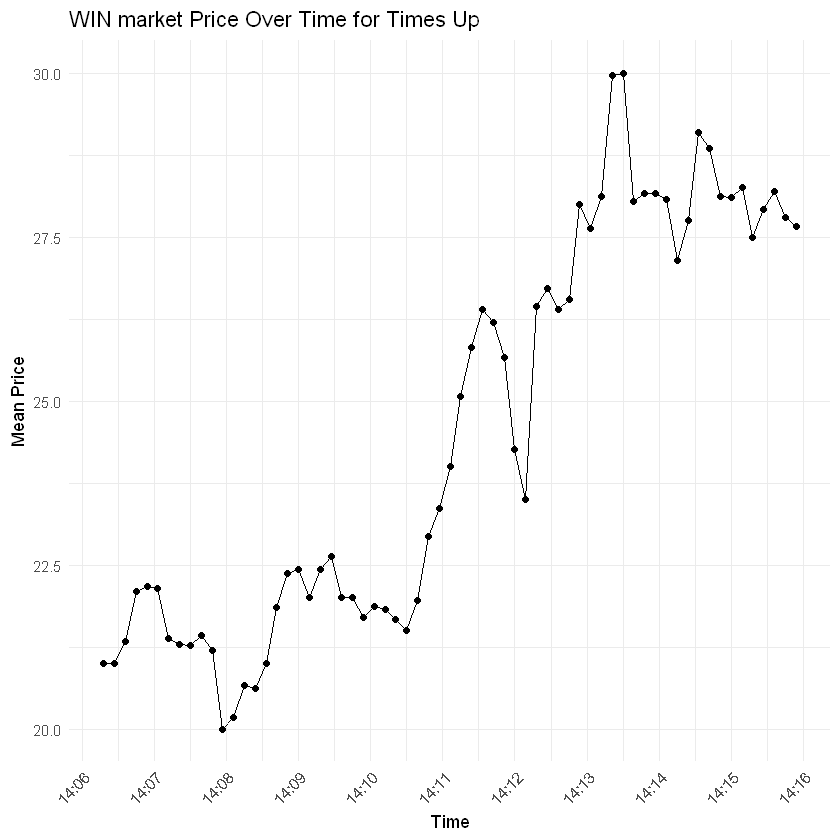

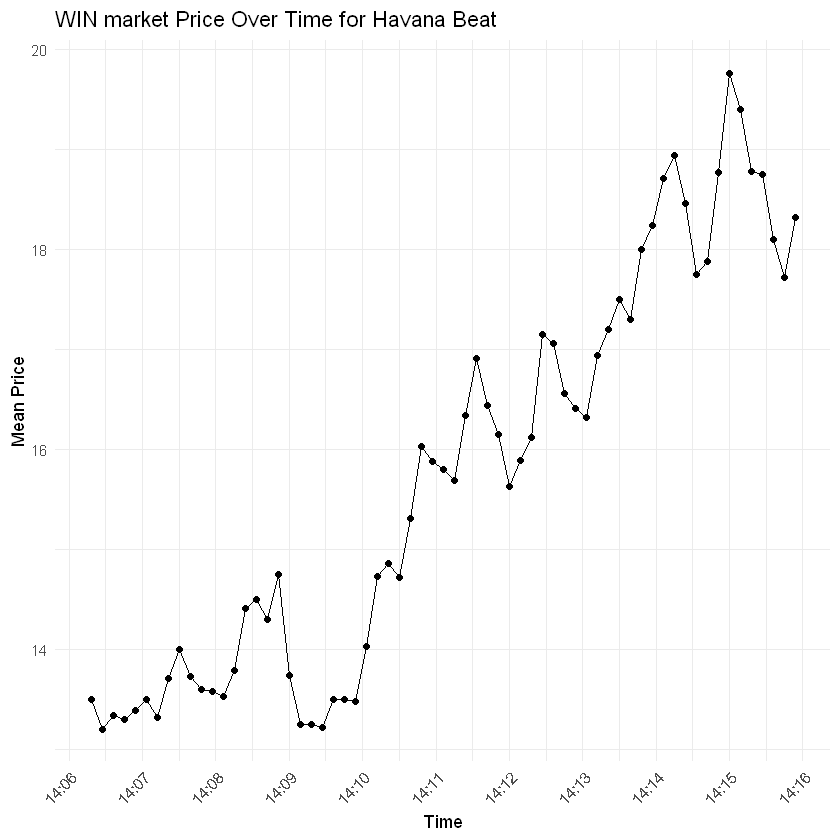

In [38]:


# Loop through each horse and create a plot and save dataframe for WIN_PRO_df
for (horse in unique(WIN_PRO_df$horse_name)) {
  horse_df <- WIN_PRO_df_PP %>% filter(horse_name == horse)
  
  # Group by time_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(time_bucket) %>%
    summarise(
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_WIN_df"), horse_df)



  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("WIN market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}
  

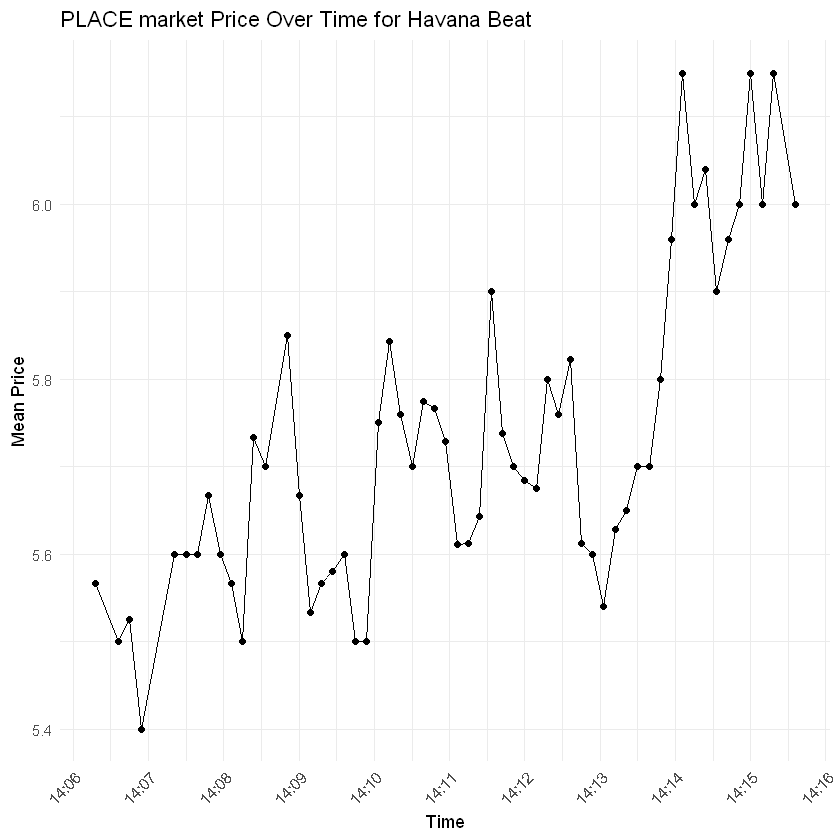

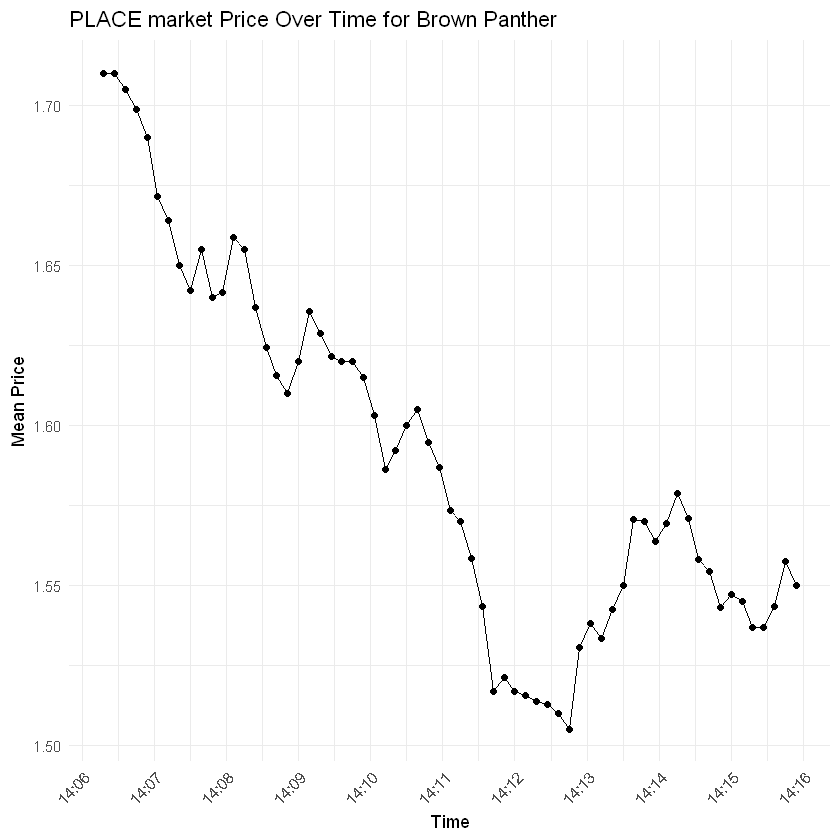

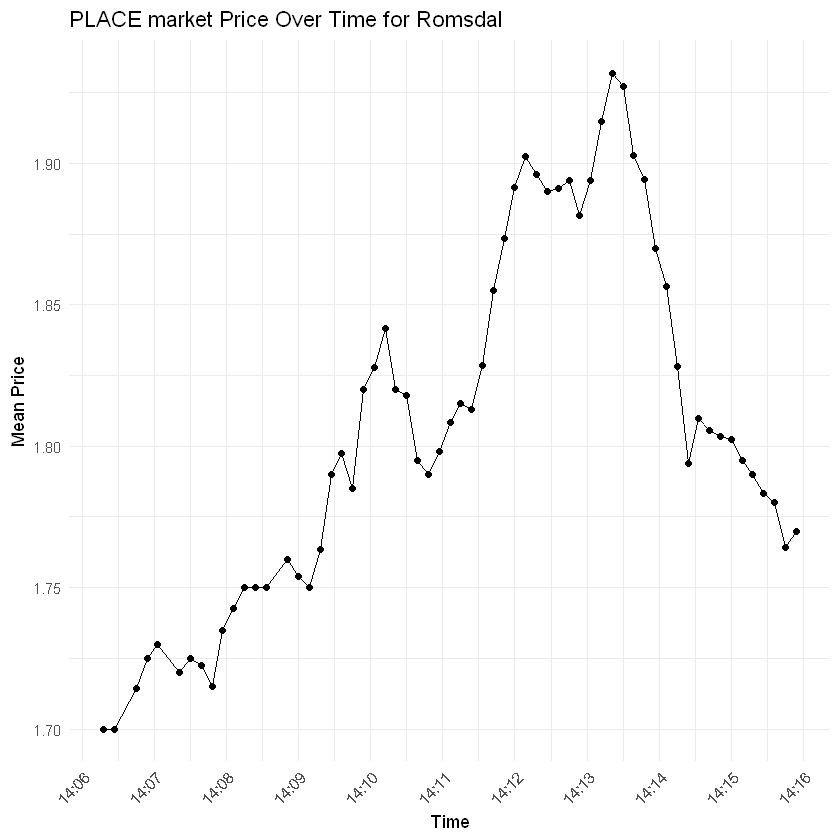

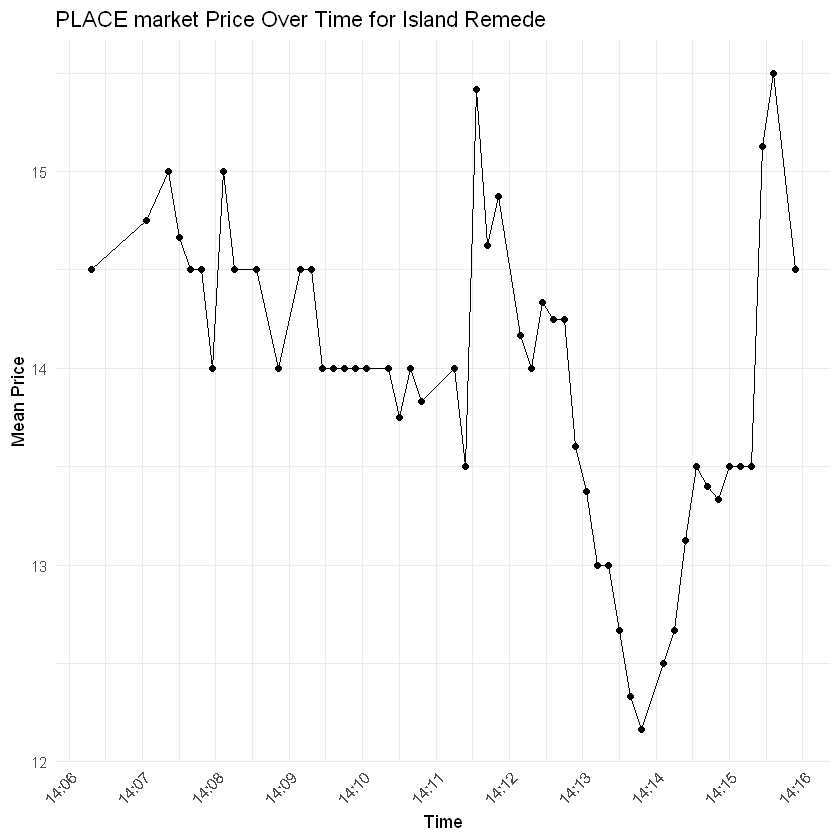

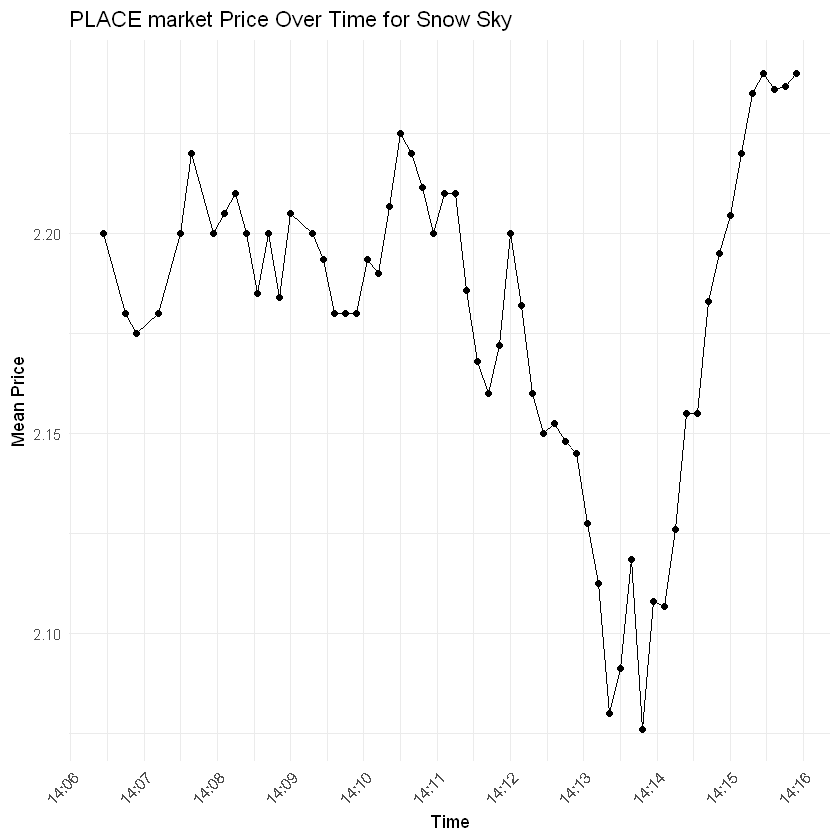

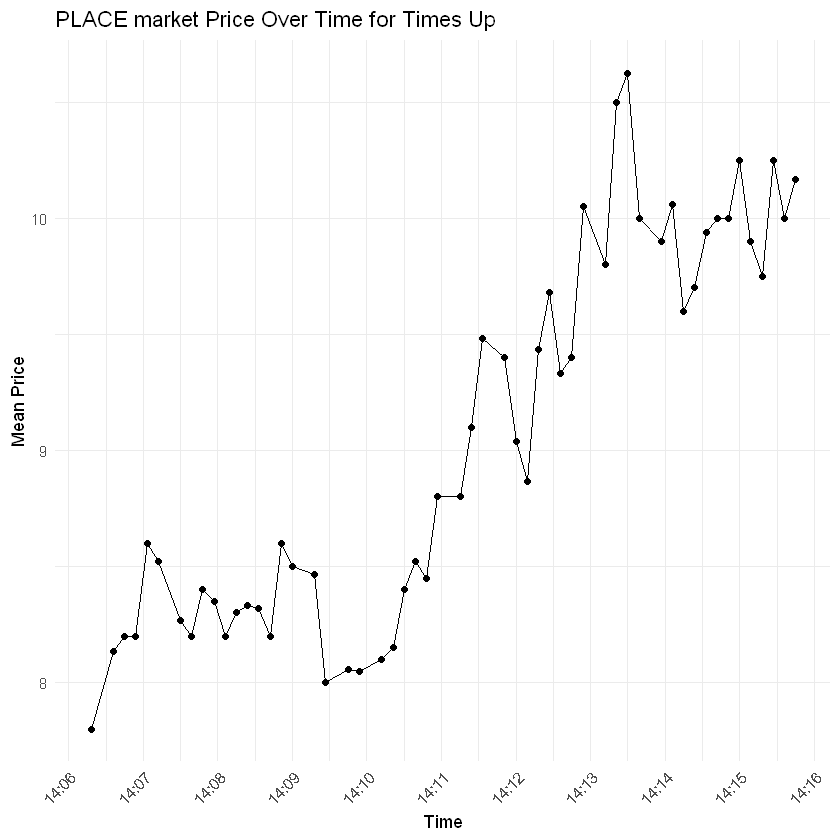

In [39]:
# Loop through each horse and create a plot and save dataframe for PLACE_PRO_df
for (horse in unique(PLACE_PRO_df$horse_name)) {
  horse_df <- PLACE_PRO_df_PP %>% filter(horse_name == horse)
  
  
  # Group by time_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(time_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      #mean_price = sum(price * size, na.rm = TRUE) / sum(size, na.rm = TRUE)
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_PLACE_df"), horse_df)
  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("PLACE market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}

### EXPLORATORY DATA ANALYSIS WIN MARKET (Brown Panther)


In [40]:
head(Brown_Panther_WIN_df)
head(Brown_Panther_PLACE_df)

time_bucket,mean_price
<dbl>,<dbl>
159077642,3.160000
159077643,3.133333
159077644,3.120455
159077645,3.154839
159077646,3.112857
159077647,3.062963


time_bucket,mean_price
<dbl>,<dbl>
159077642,1.710000
159077643,1.710000
159077644,1.705000
159077645,1.698571
159077646,1.690000
159077647,1.671429


In [41]:
# Step 2: Data Exploration
# Summary statistics of key variables

print(summary(Brown_Panther_WIN_df$mean_price))
print(summary(Brown_Panther_PLACE_df$mean_price))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.742   2.778   2.887   2.919   3.059   3.160 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.505   1.543   1.579   1.590   1.629   1.710 


In [42]:
# Check for missing and duplicates in the values
print(sum(is.na(Brown_Panther_WIN_df$mean_price)))
print(sum(is.na(Brown_Panther_PLACE_df$mean_price)))

# Check duplicate rows
print(sum(duplicated(Brown_Panther_WIN_df)))
print(sum(duplicated(Brown_Panther_PLACE_df)))

[1] 0


[1] 0
[1] 0
[1] 0


In [43]:
# Convert 'time_bucket' to POSIXct for proper time handling
Brown_Panther_WIN_df <- Brown_Panther_WIN_df %>%
  mutate(timestamp = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Brown_Panther_WIN_df$timestamp)
end_time <- max(Brown_Panther_WIN_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = Bucket_size)

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Brown_Panther_WIN_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
WIN_price_ts <- ts(filled_price_data, frequency = Bucket_size)

# Check the structure and length of the time series object
str(WIN_price_ts)
length(WIN_price_ts)

# Display the first few entries of the time series object
head(WIN_price_ts)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.742   2.778   2.887   2.919   3.059   3.160 

 Time-Series [1:65] from 1 to 8.11: 3.16 3.13 3.12 3.15 3.11 ...


[1] 65

A Time Series:
[1] 3.160000 3.133333 3.120455 3.154839 3.112857 3.062963

In [44]:
# Convert 'time_bucket' to POSIXct for proper time handling
Brown_Panther_PLACE_df <- Brown_Panther_PLACE_df %>%
  mutate(timestamp = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Brown_Panther_PLACE_df$timestamp)
end_time <- max(Brown_Panther_PLACE_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = Bucket_size)

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Brown_Panther_PLACE_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
PLACE_price_ts <- ts(filled_price_data, frequency = Bucket_size)

# Check the structure and length of the time series object
str(PLACE_price_ts)
length(PLACE_price_ts)

# Display the first few entries of the time series object
head(PLACE_price_ts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.505   1.543   1.579   1.590   1.629   1.710 

 Time-Series [1:65] from 1 to 8.11: 1.71 1.71 1.71 1.7 1.69 ...


[1] 65

A Time Series:
[1] 1.710000 1.710000 1.705000 1.698571 1.690000 1.671429

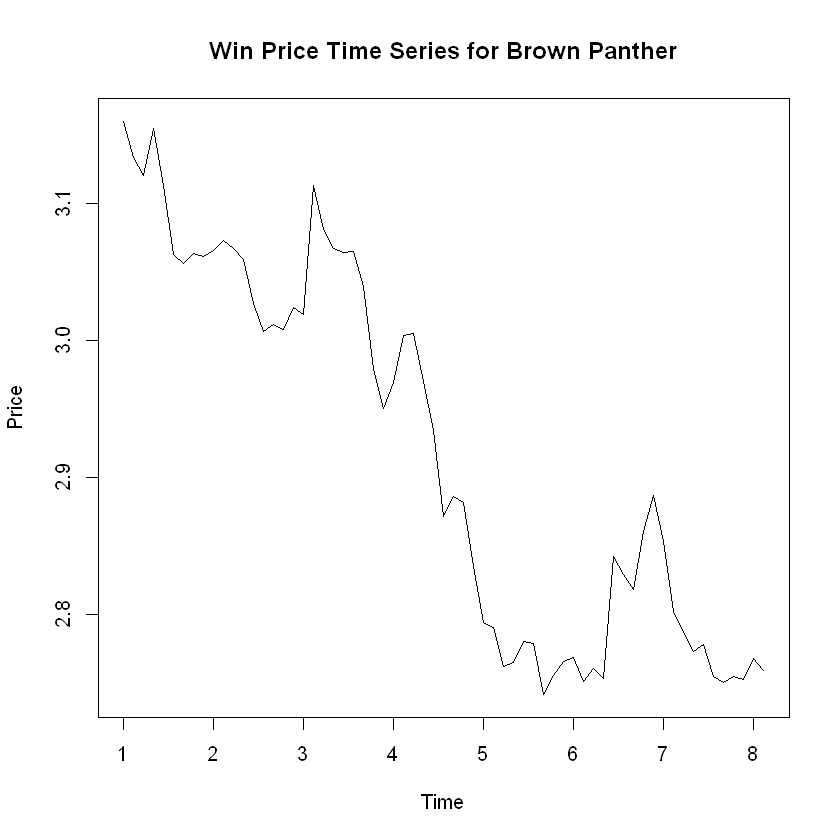

In [45]:
plot(WIN_price_ts, main="Win Price Time Series for Brown Panther", xlab="Time", ylab="Price", type="l")


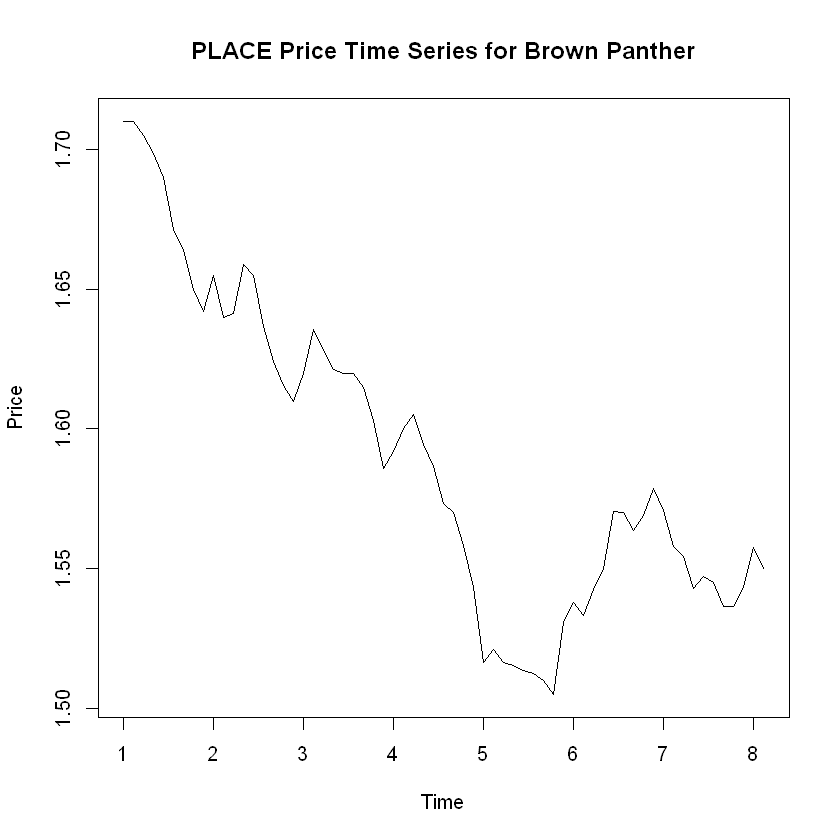

In [46]:
plot(PLACE_price_ts, main="PLACE Price Time Series for Brown Panther", xlab="Time", ylab="Price", type="l")

In [47]:
# Step 4: Statistical Tests
# Testing for stationarity
adf_test_result <- adf.test(WIN_price_ts, alternative = "stationary")
print(adf_test_result)

adf_test_result_2 <- adf.test(PLACE_price_ts, alternative = "stationary")
print(adf_test_result_2)




	Augmented Dickey-Fuller Test

data:  WIN_price_ts
Dickey-Fuller = -1.8851, Lag order = 3, p-value = 0.6216
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  PLACE_price_ts
Dickey-Fuller = -1.7995, Lag order = 3, p-value = 0.6563
alternative hypothesis: stationary



Its not stationary. Therefore we need to break it down and to understand the underlying components.


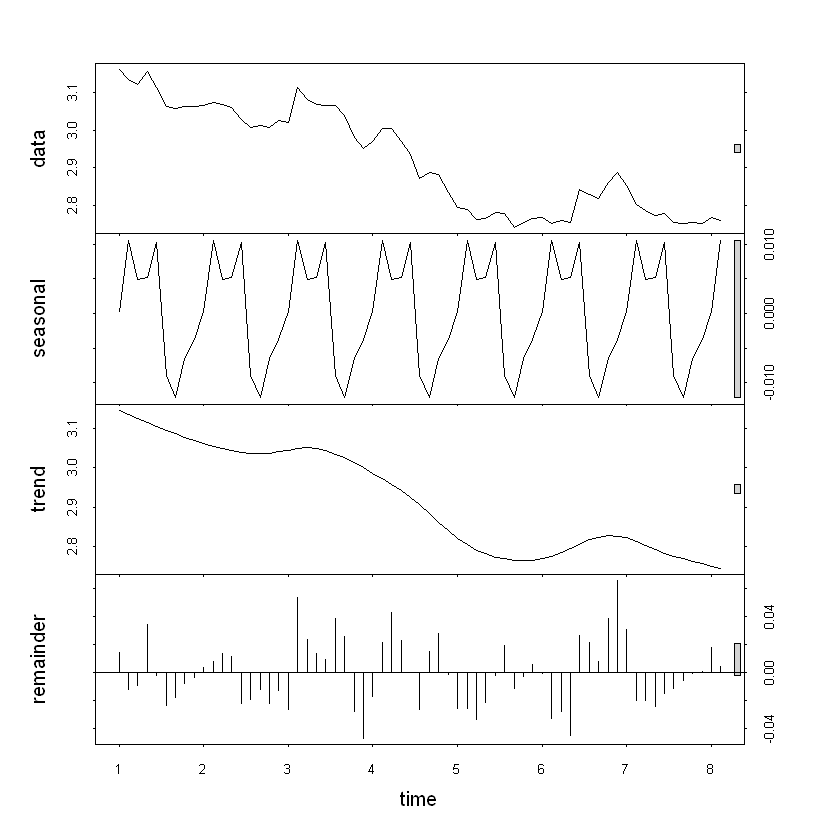

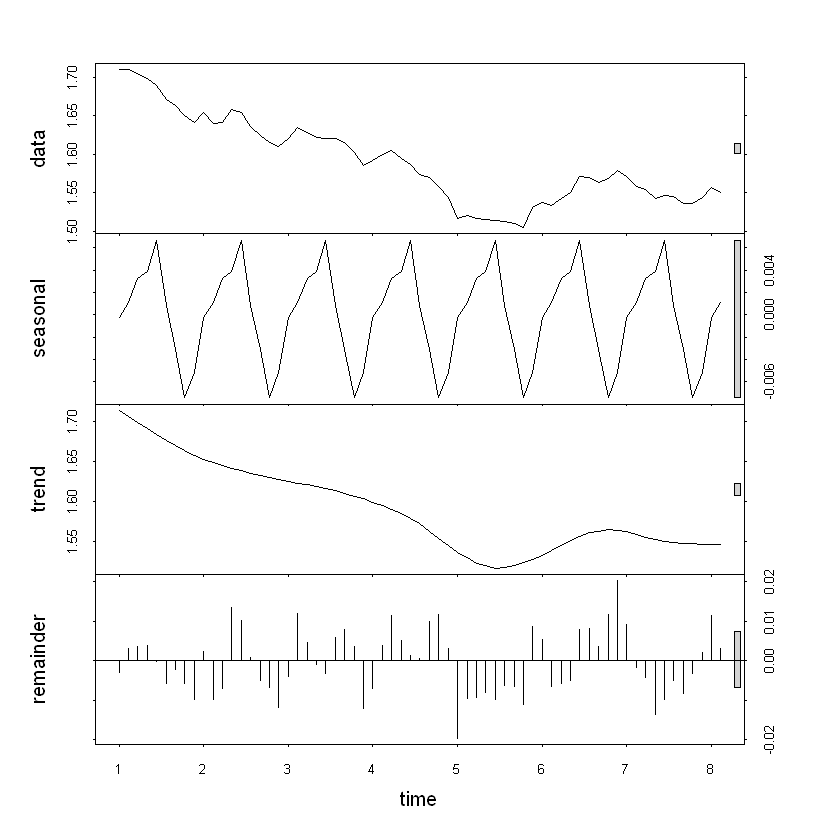

In [48]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)
decomposed <- stl(WIN_price_ts, s.window = "periodic")
plot(decomposed)

decomposed_2 <- stl(PLACE_price_ts, s.window = "periodic")
plot(decomposed_2)



In [49]:
# Step 6: Differencing 
Brown_Panther_W_diff1 <- diff(Brown_Panther_WIN_df$mean_price, lag = 1)

Brown_Panther_P_diff1 <- diff(Brown_Panther_PLACE_df$mean_price, lag = 1)


In [50]:
tail(Brown_Panther_WIN_df)
tail(Brown_Panther_PLACE_df)

head(Brown_Panther_WIN_df)
head(Brown_Panther_PLACE_df)
dim(Brown_Panther_WIN_df)
dim(Brown_Panther_PLACE_df)

# check duplicates in both dfs

sum(duplicated(Brown_Panther_WIN_df))

sum(duplicated(Brown_Panther_PLACE_df))

time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
159077701,2.755333,2015-05-15 14:15:09
159077702,2.750952,2015-05-15 14:15:18
159077703,2.755135,2015-05-15 14:15:27
159077704,2.752571,2015-05-15 14:15:36
159077705,2.768276,2015-05-15 14:15:45
159077706,2.759375,2015-05-15 14:15:54


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
159077701,1.545000,2015-05-15 14:15:09
159077702,1.536667,2015-05-15 14:15:18
159077703,1.536667,2015-05-15 14:15:27
159077704,1.543333,2015-05-15 14:15:36
159077705,1.557500,2015-05-15 14:15:45
159077706,1.550000,2015-05-15 14:15:54


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
159077642,3.160000,2015-05-15 14:06:18
159077643,3.133333,2015-05-15 14:06:27
159077644,3.120455,2015-05-15 14:06:36
159077645,3.154839,2015-05-15 14:06:45
159077646,3.112857,2015-05-15 14:06:54
159077647,3.062963,2015-05-15 14:07:03


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
159077642,1.710000,2015-05-15 14:06:18
159077643,1.710000,2015-05-15 14:06:27
159077644,1.705000,2015-05-15 14:06:36
159077645,1.698571,2015-05-15 14:06:45
159077646,1.690000,2015-05-15 14:06:54
159077647,1.671429,2015-05-15 14:07:03


[1] 65  3

[1] 65  3

[1] 0

[1] 0

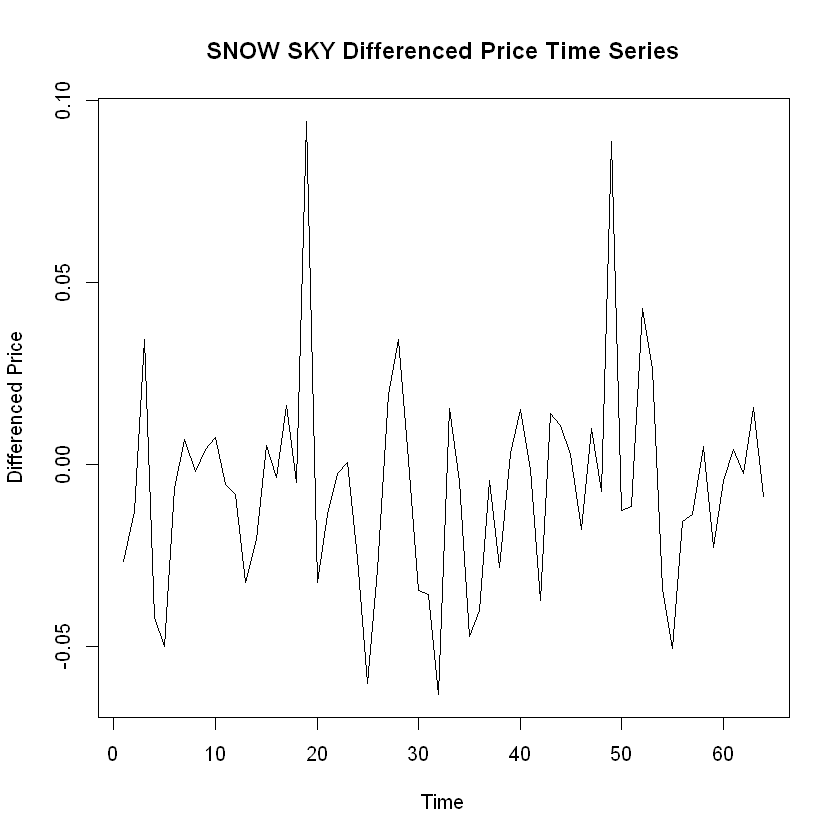

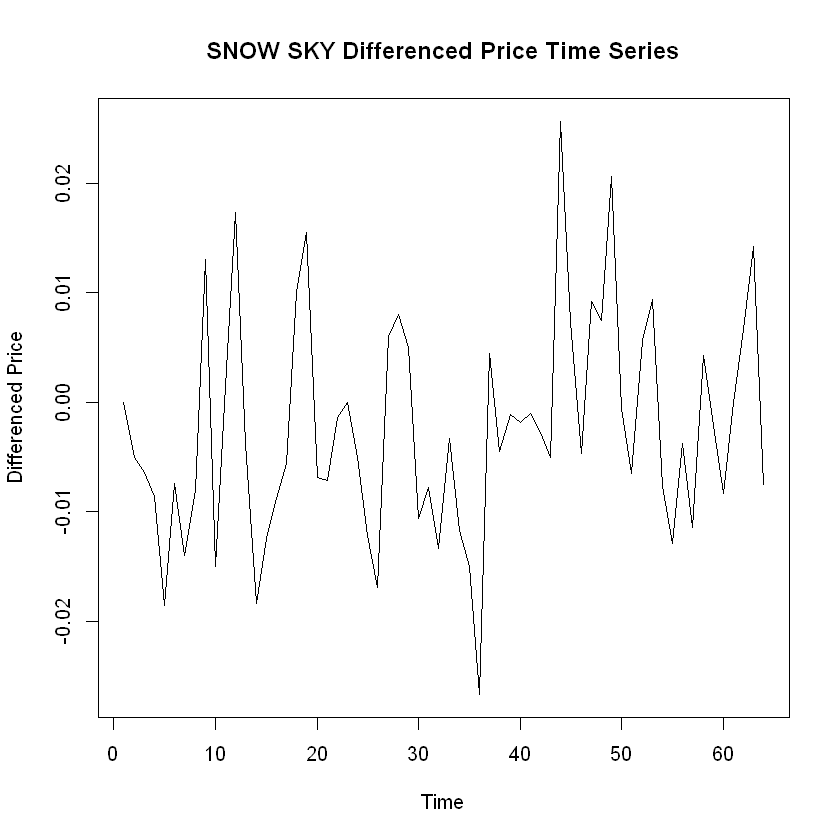

In [51]:
plot(Brown_Panther_W_diff1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

plot(Brown_Panther_P_diff1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

In [52]:
adf_result_diff <- adf.test(Brown_Panther_W_diff1, alternative = "stationary")
print(adf_result_diff)

adf_result_diff_P <- adf.test(Brown_Panther_P_diff1, alternative = "stationary")
print(adf_result_diff_P)


	Augmented Dickey-Fuller Test

data:  Brown_Panther_W_diff1
Dickey-Fuller = -3.5503, Lag order = 3, p-value = 0.04463
alternative hypothesis: stationary




	Augmented Dickey-Fuller Test

data:  Brown_Panther_P_diff1
Dickey-Fuller = -3.5071, Lag order = 3, p-value = 0.04829
alternative hypothesis: stationary



#P-Value > 0.05, hence we take do another differential


In [53]:
# 
Brown_Panther_W_diff2 <- diff(Brown_Panther_W_diff1, lag = 1)

Brown_Panther_P_diff2 <- diff(Brown_Panther_P_diff1, lag = 1)

In [54]:
print(adf.test(Brown_Panther_W_diff2, alternative = "stationary"))

print(adf.test(Brown_Panther_P_diff2, alternative = "stationary"))

Warning message in adf.test(Brown_Panther_W_diff2, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  Brown_Panther_W_diff2
Dickey-Fuller = -6.3917, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary



Warning message in adf.test(Brown_Panther_P_diff2, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  Brown_Panther_P_diff2
Dickey-Fuller = -6.6108, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary



### VAR MODEL FOR WIN MARKET AND PLACE MARKET


In [55]:
# Check the size of both the time series

length(Brown_Panther_W_diff2)
length(Brown_Panther_P_diff2)

[1] 63

[1] 63

In [56]:
# Loading required package and importing data
# install.packages("vars")
# install.packages("tseries")
# install.packages("quantmod")
library(vars)
library(tseries)
library(quantmod)

In [57]:
# Estimating vector autoregression and testing for causality

VAR_est <- VAR(cbind(Brown_Panther_W_diff2,Brown_Panther_P_diff2), ic="AIC", lag.max = 6)
coeftest(VAR_est)
causality(VAR_est, cause="Brown_Panther_W_diff2")["Granger"]
causality(VAR_est, cause="Brown_Panther_P_diff2")["Granger"]

# Interpretation: The Granger-causality test states that at the 95% confidence interval, oil returns do significantly Granger-cause the inflation rate but not vice versa.




t test of coefficients:

                                                  Estimate  Std. Error t value
Brown_Panther_W_diff2:(Intercept)               0.00054338  0.00421117  0.1290
Brown_Panther_W_diff2:Brown_Panther_W_diff2.l1 -0.66244513  0.15985447 -4.1441
Brown_Panther_W_diff2:Brown_Panther_P_diff2.l1  0.19842735  0.49776053  0.3986
Brown_Panther_W_diff2:Brown_Panther_W_diff2.l2 -0.53959457  0.18228317 -2.9602
Brown_Panther_W_diff2:Brown_Panther_P_diff2.l2  0.02248094  0.53506520  0.0420
Brown_Panther_W_diff2:Brown_Panther_W_diff2.l3 -0.34618276  0.15681776 -2.2075
Brown_Panther_W_diff2:Brown_Panther_P_diff2.l3 -0.17492945  0.47511288 -0.3682
Brown_Panther_P_diff2:(Intercept)               0.00037709  0.00145083  0.2599
Brown_Panther_P_diff2:Brown_Panther_W_diff2.l1  0.07729353  0.05507304  1.4035
Brown_Panther_P_diff2:Brown_Panther_P_diff2.l1 -0.66881872  0.17148840 -3.9001
Brown_Panther_P_diff2:Brown_Panther_W_diff2.l2  0.03682088  0.06280017  0.5863
Brown_Panther_P_diff2:Brow

$Granger

	Granger causality H0: Brown_Panther_W_diff2 do not Granger-cause
	Brown_Panther_P_diff2

data:  VAR object VAR_est
F-Test = 0.82578, df1 = 3, df2 = 106, p-value = 0.4825



$Granger

	Granger causality H0: Brown_Panther_P_diff2 do not Granger-cause
	Brown_Panther_W_diff2

data:  VAR object VAR_est
F-Test = 0.16742, df1 = 3, df2 = 106, p-value = 0.9181



In [58]:
summary(VAR_est)


VAR Estimation Results:
Endogenous variables: Brown_Panther_W_diff2, Brown_Panther_P_diff2 
Deterministic variables: const 
Sample size: 60 
Log Likelihood: 326.085 
Roots of the characteristic polynomial:
0.751 0.751 0.6799 0.6799 0.6462 0.5122
Call:
VAR(y = cbind(Brown_Panther_W_diff2, Brown_Panther_P_diff2), 
    lag.max = 6, ic = "AIC")


Estimation results for equation Brown_Panther_W_diff2: 
Brown_Panther_W_diff2 = Brown_Panther_W_diff2.l1 + Brown_Panther_P_diff2.l1 + Brown_Panther_W_diff2.l2 + Brown_Panther_P_diff2.l2 + Brown_Panther_W_diff2.l3 + Brown_Panther_P_diff2.l3 + const 

                           Estimate Std. Error t value Pr(>|t|)    
Brown_Panther_W_diff2.l1 -0.6624451  0.1598545  -4.144 0.000123 ***
Brown_Panther_P_diff2.l1  0.1984273  0.4977605   0.399 0.691760    
Brown_Panther_W_diff2.l2 -0.5395946  0.1822832  -2.960 0.004590 ** 
Brown_Panther_P_diff2.l2  0.0224809  0.5350652   0.042 0.966644    
Brown_Panther_W_diff2.l3 -0.3461828  0.1568178  -2.208 0.031627 

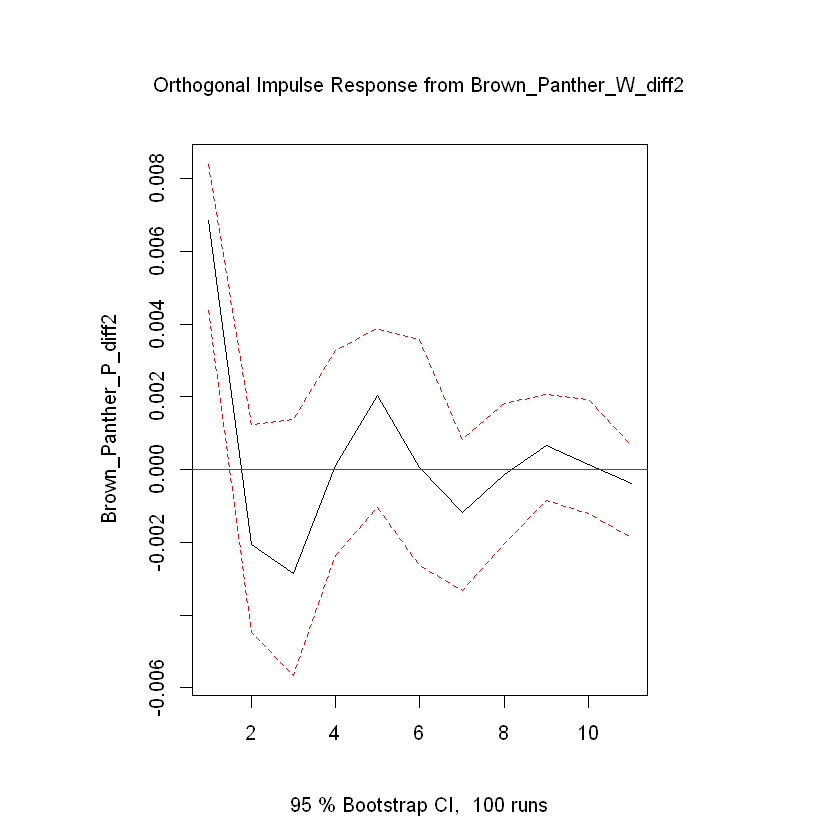

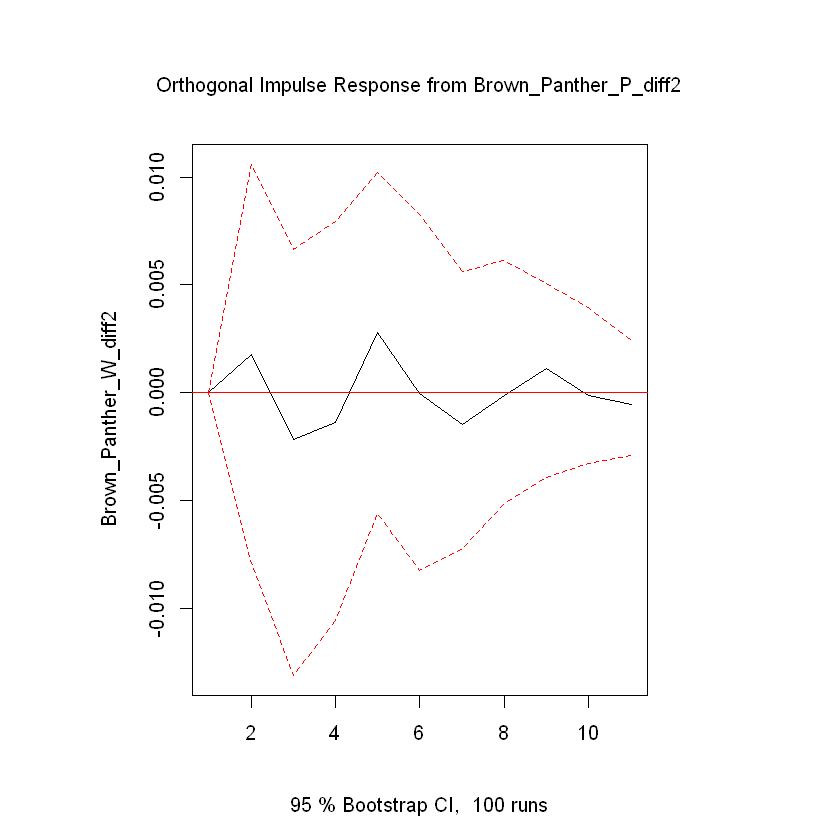

In [59]:
# Degression: Plotting impulse response functions
plot(irf(VAR_est, impulse="Brown_Panther_W_diff2", response="Brown_Panther_P_diff2"))
plot(irf(VAR_est, impulse="Brown_Panther_P_diff2", response="Brown_Panther_W_diff2"))

# Interpretation: A shock in the inflation rate does not have an effect on oil returns, whereas a shock in oil returns has a positive effect on the inflation rate in the first months after the shock.